### Movie Recommendation System using MovieLens Dataset

**Authors:** 

1. Kumari Nishu (kn2492)

2. Neelam Patodia (np2723)

3. Mohit Chander Gulla (mcg2208, github: mohitgulla)

In this notebook, we will explore two approaches to build a recommendation system using collaborative filtering algorithms: memory-based and model-based. Our analysis is based on a sampled MovieLens dataset with model training and inference implemented on Spark platform.

#### Table of Contents

1. [Objective](#objective)<br>
2. [Data Exploration](#eda)<br>
3. [Sampling Strategy](#sampling)<br>
4. [Item-Item Memory Based Collaborative Filtering](#memory-based)<br>
    4.1. [Build Weight Matrix](#weight-matrix)<br>
    4.2. [Prediction on Test Dataset](#memorypredict)<br>
    4.3. [Evaluating Model Accuracy](#memoryacc)<br>
    4.4. [Top-k Recommendations](#memoryrecommend)<br>
5. [ALS Model-Based Collaborative Filtering](#als)<br>
    5.1. [Training ALS Model](#alstrain)<br>
    5.2. [Prediction on Test Dataset](#alspredict)<br>
    5.3. [Top-k Recommendations](#alsrecommend)<br>
    5.4. [Hyperparameter Tuning](#alshyperparameter)<br>
6. [Baseline Model](#baseline)<br>
7. [Results Analysis](#results)<br>
    7.1. [Accuracy](#accuracy)<br>
    7.2. [Coverage](#coverage)<br>
    7.3. [Scalability](#scalability)<br>
8. [Conclusion & Future Work](#conclusion)

#### 1. Objective <a id = objective></a>

* *What is your objective? What are you trying to optimize and what are you willing to sacrifice?*

Our objective is to present a proof of concept on two approaches to building a recommendation system. In this notebook, we implement two collaborative filtering algorithms - a memory based and model based - and compare the performance of each in terms of accuracy, coverage, and scalability. Lastly, we want to show with conclusive evidence the value of having a recommendation system on our platform. 

* *What metrics do you care about, who is this system built to serve (users or your boss?), and what business rules may you care to introduce?*

In contrast with existing (baseline) logic of recommending movies, which is not curated for each user, we strive to learn user preferences from the ratings given to movies and provide recommendation based on that. This would improve the overall user experience by providing more targeted recommendation. Moreover investing in a sound recommendation engine would translate into customer retention and thereby increase revenue. Therefore by building a system that serves users, we as an organization would benefit in the long run.

At this stage our focus is to build a system that would provide recommendations for users that have rated at least 7 movies. This treatment is required in order for us to understand something about a user's taste and provide relevant recommendations. Our objective is to judge our model on three important aspects - accuracy, coverage and scalability. We will evaluate our model on accuracy metrics (detailed later), item and user coverage, and impact on model performance and execution time as we scale our model. Though, at the moment, our system would not provide recommendations for users with inadequate ratings, we can make use of implicit user behavior to provide recommendations to solve for the cold start problem.

In [314]:
import time
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from pyspark import SparkContext, SQLContext

from pyspark.sql.functions import *
from pyspark.sql import functions as F

from pyspark.ml.recommendation import ALS
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

#### 2. Data Exploration  <a id = eda></a>

In [315]:
# Importing MovieLens Ratings Dataset
ratings_all = pd.read_csv('data/raw/ratings.csv')

user_ratings_count = ratings_all.groupby(['userId']).count()['movieId']
movie_ratings_count = ratings_all.groupby(['movieId']).count()['userId']

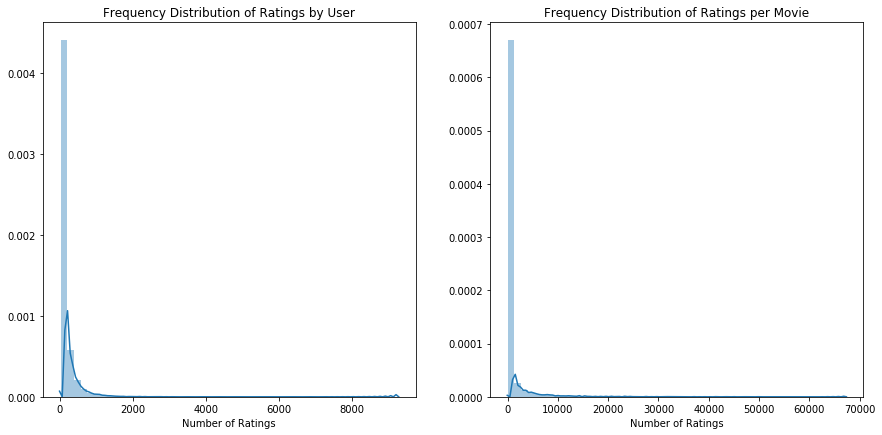

In [316]:
f, (ax1, ax2) = plt.subplots(1,2)

sns.distplot(user_ratings_count, ax = ax1)
ax1.set_title('Frequency Distribution of Ratings by User')
sns.distplot(movie_ratings_count, ax = ax2)
ax2.set_title('Frequency Distribution of Ratings per Movie')

ax1.set_xlabel('Number of Ratings')
ax2.set_xlabel('Number of Ratings')
plt.subplots_adjust(0.1, 0.1, 2, 1.4)
plt.show()

In [317]:
print('Ratings Provided by Users:')
print('Average of Ratings Count =', np.round(np.mean(user_ratings_count), 4))
print('Median of Ratings Count =', np.round(np.median(user_ratings_count), 4))

print('\nRatings Received by Movies:')
print('Average of Ratings Count =', np.round(np.mean(movie_ratings_count), 4))
print('Median of Ratings Count =', np.round(np.median(movie_ratings_count), 4))

Ratings Provided by Users:
Average of Ratings Count = 144.4135
Median of Ratings Count = 68.0

Ratings Received by Movies:
Average of Ratings Count = 747.8411
Median of Ratings Count = 18.0


From the distribution plots above, and their mean and median values, we can observe that majority of the users and movies have low ratings count. We will use this to guide our sampling strategy, as detailed below.

#### 3. Sampling Strategy <a id = sampling></a>

To build an effective recommendation model, it is vital to have a sampling strategy in place which accounts for the following parameters:

1. Removing users without significant interaction with the movie platform
As the dataset only records those users who have rated the movies, we have removed those users from the sample who have rated considerably fewer movies as compared to other as they represent outliers and recording their movie ratings would not represent true ratings. To determine this cutoff, we follow the following approach: Remove the lower 10% of the outliers based on the frequency of their ratings count.


2. Choosing popular versus unpopular movie choice:
We have tried to achieve a balance between choice of both popular and non-popular movies by considering either of the 2 options : the quantiles of number of ratings per movie and a fixed threshold. On the initial sampling data of 500/600 items we observed that beyond 75%ile the ratings had shot up from 3-4 ratings to more than 1000s. We thus thought of using a threshold value of 5 for including items in our sampling data. This was done to ensure that even after selection of a particular number of items from the whole data, in the end sampled data the number of items which have just one user associated with them is minimized. It should be noted here, that even though the initial frequency has been set above 5, this does not ensure that in the end data the frequency would be more than 5. 


3. Removing movies without significant user interaction:
Now that we have filtered our users and items at an initial level, in order to ensure that in the end data high user engagement is maintained we have used threshold value of 7 which denotes that the recommender system would only recommend to those users which have rated more than 7 movies. This could also be interpreted as a business rule. This is also important as we intend to use item-item CF and thus ensuring user engagement beyond a certain level, ensures pair wise ratings comparisons. Else the sparsity would increase even more.


4. Model Scalability:
As we go on increasing the size of our sampled data, it is necessary to decide on how many items we would consider in each pull as it would be associated to the number of users and the number of rows we have in the sampled data. 


5. Generate train and test data:
We have assured that all users are present in both test and train data. This is because the system cannot recommend for new users i.e those who have not appeared in the training dataset. To solve for cold start problem is an enhancement we can do in future. As such, 80% of the movies which a user has seen appears in train data and the latter in test data. We have ensured that only those users are present in the sampled data who have rated more than 7 movies, thus this is further verified.

We have thus tried to build a sampling function called 'data_sampling' which covers all these functionalities mentioned above and outputs the sample data to be used for model building and analysis. 

In [318]:
def data_sampling (df, item_nos=500, item_split=[0.90,0.10]):
    
    # Data preprocessing from user perspective
    
    # Frequency of movie rating by each user
    user_rtgs_cnt = (df.groupby(['userId']).count()). \
        iloc[:,0:1].reset_index().rename(columns={"movieId":"rating_cnt"})
    
    quantile_user = user_rtgs_cnt.quantile([0.1, 0.25, 0.75, 0.9], axis = 0).drop(["userId"], axis = 1)
    
    # Removing the lower 10% of the outliers.
    user_rtgs_cnt=user_rtgs_cnt[user_rtgs_cnt.rating_cnt>=quantile_user.iloc[0,0]]
    
    # These users are then removed from the dataset
    df = df.merge(user_rtgs_cnt[['userId']],on="userId", how="inner")   
    
    # Data preprocessing from item perspective
    
    # Count of Ratings per movie
    item_count = (df[["movieId","rating"]].groupby(['movieId']).count()). \
        reset_index().rename(columns={"rating":"rating_per_item"})
    
    quantile_item=item_count.quantile([0.1,.25,.75,1], axis = 0).drop(["movieId"],axis=1)
    
    # Removing all items which have less than 3 user counts i.e Q1 or based on a fixed number 
    item_count = item_count[item_count.rating_per_item>=5].reset_index(drop=True)
    item_count["item_subset"] = np.where(item_count.rating_per_item < quantile_item.iloc[2,0],1,2)
    
    # Data Sampling 
    
    sampled_ratings=pd.DataFrame()
    j = len(item_split)-1
    
    for i in item_count.item_subset.unique():
        sampled_ratings=sampled_ratings.append(item_count[item_count.item_subset==i]. \
                                               sample(n=int(item_split[j]*item_nos), random_state=10))
        j=j-1
        
    sampled_ratings.reset_index(drop=True, inplace=True)
    
    # Select user rows for only those movies which have been sampled
    df = df.merge(sampled_ratings[['movieId']],on="movieId", how="inner")
    
    # Since not all items are selected it may happen that we again get items with only user frequency.
    # Removing single frequency users so as to reduce sparsity and enable item-item comparison between pairs
    
    user_rtgs_cnt_2=(df.groupby(['userId']).count()).iloc[:,0:1]. \
        reset_index().rename(columns={"movieId":"user_freq"})
    df = df.merge(user_rtgs_cnt_2,on="userId", how="inner")
    
    # For any personalized recommendation to a user, we are setting a rule that user should have 
    # watched at least 7 movies then only make popular recommendations to him
    df = df[df.user_freq>7] 
    df.drop(['user_freq'],axis=1, inplace=True)
    df = df.reset_index(drop=True)
    print("Total Number of Ratings in Sampled Dataset =", len(df))
    print("Total Number of Unique Users in Sample =", len(df.userId.unique()))
    
    # Train-Test Split
    
    df_train = df.groupby(['userId']).apply(lambda x : x.sample(frac=0.8,random_state=10)).reset_index(drop=True)
    z = df.merge(df_train,how='outer', on=['userId','movieId','rating','timestamp'], indicator=True)
    df_test = z.query('_merge != "both"')
    df_test = df_test.drop(['_merge'],axis=1)
    df_test.reset_index(drop=True, inplace=True)
        
    return [df, df_train, df_test]

In [319]:
ratings, ratings_training, ratings_test = data_sampling(ratings_all, item_nos = 500)

Total Number of Ratings in Sampled Dataset = 54836
Total Number of Unique Users in Sample = 4201


#### 4. Item-Item Memory Based Collaborative Filtering <a id = memory-based></a>

**Item-Item Based Approach**: Item-Item based approach takes an item, finds users who liked that item then finds other items liked by those users. Item-Item Collaborative Filtering is best described by the quote *“users who liked this item also liked …”*.

**Memory Based Approach**: In memory based collaborative filtering approach, we do not learn any parameter using gradient descent or any optimization technique. The closest user or items are calculated by using some similarity metrics(as Cosine similarity or Pearson correlation) which are only based on arithmetic operations. As no training or optimization is involved, it is an easy to use approach.

Here we have used Item-item and memory based collaborative filtering using cosine similarity as the measure of similarity between different items.

**Cosine Similarity**: Cosine similarity is a method to measure the difference between two non zero vectors of an inner product space. The cosine similarity will measure the similarity between these two vectors. Cosine similarity can be thought of geometrically as below when we treat a given item’s (user’s) column (row) of the ratings matrix as a vector.

For item-based collaborative filtering, two items’ similarity is measured as the cosine of the angle between the two items’ vectors. 

For items *b* and *c*, the cosine similarity is:
            $$Similarity: \cos(\theta) = \frac{b.c}{\left \|b \right \|\left \|c \right \|}$$

##### 4.1 Build Weight Matrix <a id = weight-matrix></a>

The function defined below will build an item-to-item matrix which will be used for prediction later.

In [320]:
def build_weight_matrix(ratings):
    
    # define weight matrix
    w_matrix_columns = ['movie_1', 'movie_2', 'weight']
    w_matrix = pd.DataFrame(columns = w_matrix_columns)

    # calculate the similarity between pairs of movies
    unique_movies = np.unique(ratings['movieId'])
    print("Number of Unique Movies = ", len(unique_movies))

    for movie_1 in unique_movies:

        # extract all users who rated movie_1
        user_data = ratings[ratings['movieId'] == movie_1]
        unique_users = np.unique(user_data['userId'])

        # record the ratings for users who rated both movie_1 and movie_2
        record_row_columns = ['userId', 'movie_1', 'movie_2', 'rating_1', 'rating_2']
        record_movie_1_2 = pd.DataFrame(columns=record_row_columns)
        
        # for each customer C who rated movie_1 record the her ratings for movie_2 
        for c_userid in unique_users:
            c_movie_1_rating = user_data[user_data['userId'] == c_userid]['rating'].iloc[0]
            # all movies of user c excluding movie_1
            c_user_data = ratings[(ratings['userId'] == c_userid) & (ratings['movieId'] != movie_1)]
            c_unique_movies = np.unique(c_user_data['movieId'])

            # Iterate through all movies rated by customer C as movie=2
            for movie_2 in c_unique_movies:
               # the customer's rating for movie_2
                c_movie_2_rating = c_user_data[c_user_data['movieId'] == movie_2]['rating'].iloc[0]
                record_row = pd.Series([c_userid, movie_1, movie_2, c_movie_1_rating, c_movie_2_rating], 
                                       index=record_row_columns)
                record_movie_1_2 = record_movie_1_2.append(record_row, ignore_index=True)
        
        # computing the similarity between movie_1 and the other recorded movies tagged as movie_2
        unique_movie_2 = np.unique(record_movie_1_2['movie_2'])
        # going through each movie 2
        for movie_2 in unique_movie_2:
            paired_movie_1_2 = record_movie_1_2[record_movie_1_2['movie_2'] == movie_2]
            cosine_sim_numerator = (paired_movie_1_2['rating_1'] * paired_movie_1_2['rating_2']).sum()
            cosine_sim_denominator = np.sqrt(np.square(paired_movie_1_2['rating_1']).sum()) * \
                np.sqrt(np.square(paired_movie_1_2['rating_2']).sum())
                
            cosine_sim_denominator = cosine_sim_denominator if cosine_sim_denominator != 0 else 1e-8
            sim_value = cosine_sim_numerator / cosine_sim_denominator
            w_matrix = w_matrix.append(pd.Series([movie_1, movie_2, sim_value], index=w_matrix_columns), 
                                       ignore_index=True)
            
    #return the computed weight matrix
    return w_matrix

In [321]:
start = time.time()
print('Building Weight Matrix - Item-Item Collaborative Filtering...')
w_matrix = build_weight_matrix(ratings_training)
print('Weight Matrix Successfully Built')
end = time.time()
print('\nTime Elapsed = '+str(end - start)+' secs')

Building Weight Matrix - Item-Item Collaborative Filtering...
Number of Unique Movies =  499
Weight Matrix Successfully Built

Time Elapsed = 1264.2378659248352 secs


##### 4.2 Prediction on Test Dataset<a id = memorypredict></a>

The function defined below will predict the rating of an unrated movie for a given user.

Prediction of rating for a pair of given item and user is done using the similarity of the given item with all the items and the rating given by the current user for all those items. Then we further normaize this summation by the sum of similarity scors for all those items.

In [322]:
# Predict a rating for a given user and given movie
def predict(userId, movieId, w_matrix, ratings):
    # predict the rating of the given movie by the given user
    user_other_ratings = ratings[ratings['userId'] == userId]
    user_unique_movies = np.unique(user_other_ratings['movieId'])
    sum_weighted_other_ratings = 0
    sum_weghts = 0
    for movie_j in user_unique_movies:
        # only calculate the weighted values when the weight between movie_1 and movie_2 exists in weight matrix
        w_movie_1_2 = w_matrix[(w_matrix['movie_1'] == movieId) & (w_matrix['movie_2'] == movie_j)]
        if len(w_movie_1_2) > 0:
            user_rating_j = user_other_ratings[user_other_ratings['movieId']==movie_j]
            sum_weighted_other_ratings += (user_rating_j['rating'].iloc[0] * w_movie_1_2['weight'].iloc[0])
            sum_weghts += np.abs(w_movie_1_2['weight'].iloc[0])

    # when sum_weights is 0 (in case there is no ratings from new users), use the mean ratings as 2.5
    if sum_weghts == 0:
        predicted_rating = 2.5
    else:
        predicted_rating = sum_weighted_other_ratings/sum_weghts
    predicted_rating = np.round(predicted_rating, 4)
    return predicted_rating

##### 4.3 Evaluating Model Accuracy<a id = memoryacc></a>

We will evaluate the accuracy of our item-item memory based collaborative filtering using RMSE and MAE. Detailed analysis in the results section.

In [323]:
# Evaluate the learned recommender system on test data by converting the ratings to negative and positive
def rmse_eval(ratings_test, w_matrix, ratings_training):
    # predict all the ratings for test data
    ratings_test['prediction'] = pd.Series(np.zeros(ratings_test.shape[0]))
    
    for index, row_rating in ratings_test.iterrows():
        predicted_rating = predict(row_rating['userId'], row_rating['movieId'], w_matrix, ratings_training)
        ratings_test.loc[index, 'prediction'] = predicted_rating
    
    rmse = np.round(np.sqrt(np.mean((ratings_test['prediction']-ratings_test['rating'])**2)), 4)
    mae = np.round(np.mean(np.abs(ratings_test['prediction']-ratings_test['rating'])), 4)
    ratings_test.drop(['prediction'], inplace=True, axis = 1)
    return rmse, mae

In [350]:
start = time.time()
print('Evaluating RMSE, MAE on test dataset...')
rmse, mae = rmse_eval(ratings_test, w_matrix, ratings_training)
print('RMSE on Test Dataset = ', rmse)
print('MAE on Test Dataset = ', mae)
end = time.time()
print('\nTime Elapsed = '+str(np.round(end - start, 4))+' secs')

Evaluating RMSE, MAE on test dataset...
RMSE on Test Dataset =  0.8833
MAE on Test Dataset =  0.7612

Time Elapsed = 283.7822 secs


##### 4.4 Top-k Recommendations<a id = memoryrecommend></a>

In prediction step, We implemented the utility to predict the rating of an unrated movie by a given user. In this step, we obtain a complete rating list of all the unrated movies by the user. Then we obtain the top K movies with maximum ratings predicted. This list of top K movies are most likely to attract the user.

In [325]:
# recommend top k movies for given userId from movies that he/she has not seen
def recommend(userID, w_matrix, ratings, k=10):
    
    distinct_movies = np.unique(ratings['movieId'])
    user_rated_movies = np.unique(ratings[ratings['userId']==userID]['movieId'])

    user_unrated_movies = pd.DataFrame(columns=['movieId', 'rating'])

    # predict the ratings for all movies that the user hasn't rated
    i = 0
    for movie in distinct_movies:
        if movie not in user_rated_movies:
            rating_value = predict(userID, movie, w_matrix, ratings)
            user_unrated_movies.loc[i] = [movie, rating_value]
            i = i + 1
        else:
            continue
            
    # select top k movies based on predicted ratings
    recommendations = user_unrated_movies.sort_values(by=['rating'], ascending=False).head(k)
    recommendations_list = [ [int(row['movieId']), row['rating']] for i,row in recommendations.iterrows() ]
    return recommendations_list

In [326]:
# taking top k recommendation for given list of users
def make_recommendation_for_users(users_list, ratings_training):
    users_recommendations_df = pd.DataFrame(columns=['userId', 'recommendation'])
    count = 0
    for user in users_list:
        recommendations = recommend(user, w_matrix, ratings_training, k=10)
        users_recommendations_df.loc[count] = [user, recommendations]
        count+=1
        
    return users_recommendations_df

In [336]:
start = time.time()
print('Recommending 10 movies for all users...')
users_list_for_recommendation = list(set(ratings_training['userId']) & set(ratings_test['userId']))
users_recommendations_df = make_recommendation_for_users(users_list_for_recommendation, ratings_training)
print('Recommendations Successfully Generated')

end = time.time()
print('\nTime Elapsed = '+str(np.round(end - start, 4))+' secs')

users_recommendations_df.head()

Recommending 10 movies for all users...
Recommendations Successfully Generated

Time Elapsed = 4416.535 secs


,userId,recommendation
0,122882,"[[114856, 4.75], [117726, 4.75], [55659, 4.75]..."
1,8197,"[[114856, 4.0], [107000, 4.0], [87100, 4.0], [..."
2,65542,"[[55757, 4.4054], [1462, 4.3294], [110748, 4.3..."
3,57355,"[[49183, 5.0], [87036, 5.0], [107743, 5.0], [9..."
4,32780,"[[113557, 4.2568], [117726, 4.125], [95163, 4...."


#### 5. ALS Model-Based Collaborative Filtering <a id = als></a>
Alternating Least Squares (ALS) is a matrix factorization algorithm that works well for large scale collaborative filtering problems. It performs well with sparse ratings dataset, and scales well to very large datasets - two features that make it a good choice for real world recommendation systems.

In the background, ALS is an optimization problem that is trying to minimize the objective function: 

$$Minimize: J = \frac{1}{2}\left \| R - UV^{T} \right \|; Constraints: U\geq 0, V\geq 0$$

where U and V represent the latent factors of our user-movie matrix, R corresponds to the actual rating and hence J is the loss that we are trying to minimize. 

ALS is a two-step iterative optimization process where it first holds the user matrix fixed and runs gradient descent with the movie matrix, and then holds the movie matrix fixed and runs gradient descent with the item matrix. We have implemented this below using the Spark ML library in Python.

In [338]:
sc = SparkContext()
sqlContext = SQLContext(sc)

# Converting pandas DataFrame to pyspark DataFrame
ratings_test_sc = sqlContext.createDataFrame(ratings_test)
ratings_training_sc = sqlContext.createDataFrame(ratings_training)

ratings_test_sc = ratings_test_sc.select(['userId', 'movieId', 'rating', 'timestamp'])

##### 5.1 Training ALS Model / Cross-Validation Setup <a id = alstrain></a>
In the function defined below, we have fit the ALS model on our training dataset. The various design choices made in training the model are detailed below:
1. The nonnegative hyperparameter to the ALS model is set to *True* which puts the constraints on U, V to be greater than 0 as rating values are non-negative
2. We have chosen to tune two of the most important hyperparameters of ALS: **rank** - the number of latent factors and **regParam** - the regularization factor over a set of values that are built into a parameter grid
3. We are learning the optimal values of hyperparameters using cross validation with 4 folds and our evaluation metric is root-mean squared error (RMSE)

In [339]:
def als_model_train(train):
    # Initializing implicit ALS with user, movie and ratings column
    als = ALS(userCol="userId", 
              itemCol="movieId", 
              ratingCol="rating",
              nonnegative=True,
              coldStartStrategy="drop")
    
    # We use a ParamGridBuilder to construct a grid of parameters to search over
    param_grid = ParamGridBuilder() \
        .addGrid(als.rank, [25, 50, 75, 100]) \
        .addGrid(als.regParam, [0.01, 0.1, 0.25, 0.5]) \
        .build()
    
    # Defining the evaluation criteria for choosing best set of hyperparameters
    evaluator = RegressionEvaluator(metricName="rmse", 
                                    labelCol="rating", 
                                    predictionCol="prediction")
    
    # To try all combinations of hyperparameters and determine best model using evaluator
    hypertuned = CrossValidator(estimator=als, 
                                estimatorParamMaps=param_grid, 
                                evaluator=evaluator,
                                numFolds=4)
    
    # Choosing the best set of hyperparameters from cross validation
    cvModel = hypertuned.fit(train)
    
    return cvModel

In [340]:
start = time.time()
print('Initiating ALS Model Training...')
model = als_model_train(ratings_training_sc)
print('ALS Model Training Complete')
end = time.time()
print('\nTime Elapsed = '+str(np.round(end - start, 4))+' secs')

Initiating ALS Model Training...
ALS Model Training Complete

Time Elapsed = 543.4539 secs


##### 5.2 Prediction on Test Dataset <a id = alspredict></a>
In the function defined below, we use the best trained model from our hyperparameter tuning to predict ratings for user-movie pairs present in the test dataset. This allows us to gauge the performance of our model on unseen data. We are evaluating the performance of our ALS model using RMSE. Prior to calculating RMSE, we are capping all predicted ratings of more than 5 to 5 as the actual ratings data is in the range 0-5.

In [341]:
def als_model_predict(model, test):
    predictions = model.bestModel.transform(test)
    # Capping all predictions that exceed 5 to the max rating 5
    predictions = predictions.withColumn('prediction', 
                                         when(col('prediction') > 5, 5).otherwise(col('prediction')))
    evaluator_rmse = RegressionEvaluator(metricName="rmse", labelCol="rating", predictionCol="prediction")
    evaluator_mae = RegressionEvaluator(metricName="mae", labelCol="rating", predictionCol="prediction")
    
    rmse = np.round(evaluator_rmse.evaluate(predictions), 4)
    mae = np.round(evaluator_mae.evaluate(predictions), 4)
    
    return rmse, mae

In [342]:
start = time.time()
print('Predicting on Test Dataset...')
rmse, mae = als_model_predict(model, ratings_test_sc)
print('RMSE on Test Dataset = ', np.round(rmse, 4))
print('MAE on Test Dataset = ', np.round(mae, 4))
end = time.time()
print('\nTime Elapsed = '+str(np.round(end - start, 4))+' secs')

Predicting on Test Dataset...
RMSE on Test Dataset =  0.8818
MAE on Test Dataset =  0.698

Time Elapsed = 5.1415 secs


##### 5.3 Top-k Recommendations <a id = alsrecommend></a>
In the function defined below, we are using the inbuilt Spark ALS method *recommendForAllUsers( )* method to generate recommendations for all users. It will only return recommendations for users for whom we have data when training our ALS model. Essentially our recommendation system built on ALS would not be able to provide recommendations for new users, i.e. users who have not provided any ratings.

Before providing the final set of recommendations for each user, we filter out the movies the user has already rated from the set of top-k recommendations we provide for the user. We are performing this filteration as our end objective is to recommend to users, the top-k movies that they have not rated/consumed. 

In [343]:
def als_model_recommend(model, k = 10):
    user_recs = model.bestModel.recommendForAllUsers(len(np.unique(ratings['movieId'])))
    user_recs_pd = user_recs.toPandas()
    user_rated = ratings.copy()
    
    # Populating a dictionary for each user with the list of movies that they have rated
    user_rated_movies = user_rated.groupby('userId')['movieId'].apply(lambda x: x.values.tolist()).to_dict()
    user_movie_recs = pd.DataFrame(columns = ['userId', 'recommendations'])
    
    for i in range(len(user_recs_pd)):
        userID = user_recs_pd['userId'][i]
        user_movie_recs.loc[i, 'userId'] = userID
        rated_movies = user_rated_movies.get(userID)
        
        count = 0
        recommendations = []
        for j in range(len(user_recs_pd.loc[i, 'recommendations'])):
            
            # Only movies not rated by a user makes it into their recommendation 
            if(user_recs_pd.loc[i, 'recommendations'][j][0] not in rated_movies):
                recommendations.append((user_recs_pd.loc[i, 'recommendations'][j][0], 
                                        user_recs_pd.loc[i, 'recommendations'][j][1]))
                count = count + 1

            # Stopping as soon as we have our top-k recommendations ready
            if(count == k):
                user_movie_recs.loc[i, 'recommendations'] = recommendations
                break
    
    return user_movie_recs

In [344]:
start = time.time()
print('Recommending 10 movies for all users...')
user_movie_recs = als_model_recommend(model, 10)
print('Recommendations Successfully Generated')
end = time.time()
print('\nTime Elapsed = '+str(np.round(end - start, 4))+' secs')

user_movie_recs.head()

Recommending 10 movies for all users...
Recommendations Successfully Generated

Time Elapsed = 18.3217 secs


,userId,recommendations
0,73470,"[(102602, 3.5221798419952393), (72035, 3.46410..."
1,23571,"[(72035, 2.547758102416992), (102602, 2.507508..."
2,25591,"[(72035, 4.282489776611328), (87207, 3.8047587..."
3,63271,"[(72035, 4.301156044006348), (107743, 3.998626..."
4,124861,"[(72035, 4.826237678527832), (107743, 4.463072..."


##### 5.4 Hyperparameter Tuning  <a id = alshyperparameter></a>
In order to learn the hyperparameters of our ALS model, that give us the best results, we essentially trained 9 models with different combinations of *rank* and *regParam* values as specified. Observing RMSE values from the models trained with different hyperparameters can give us an indication if we need to further tune our parameters as there might be scope to extract more performance. Finally, we would use the best fit model for predictions and recommendations.

In [345]:
params = [{p.name: v for p, v in m.items()} for m in model.getEstimatorParamMaps()]
tuning_results = pd.DataFrame.from_dict([
    {model.getEvaluator().getMetricName(): metric, **ps} 
    for ps, metric in zip(params, model.avgMetrics)
])

tuning_results

,rank,regParam,rmse
0,25,0.01,1.255248
1,25,0.10,0.988724
2,25,0.25,0.917121
3,25,0.50,1.000890
4,50,0.01,1.187884
5,50,0.10,0.988476
6,50,0.25,0.918973
7,50,0.50,1.000932
8,75,0.01,1.048006
9,75,0.10,0.984515


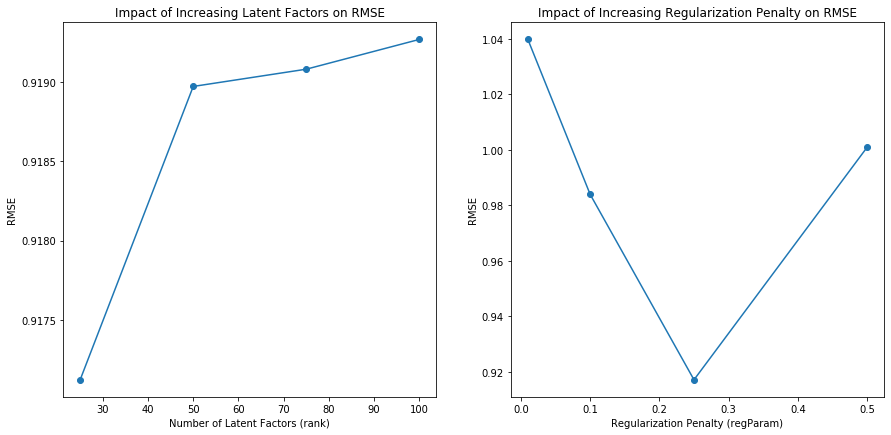

In [346]:
plt.subplots_adjust(0.1, 0.1, 2, 1.4)

plt.subplot(1, 2, 1)
plt.plot(tuning_results['rank'].unique(), tuning_results.groupby(['rank']).min()['rmse'], marker = 'o')
plt.title('Impact of Increasing Latent Factors on RMSE')
plt.xlabel('Number of Latent Factors (rank)')
plt.ylabel('RMSE')

plt.subplot(1, 2, 2)
plt.plot(tuning_results['regParam'].unique(), tuning_results.groupby(['regParam']).min()['rmse'], marker = 'o')
plt.title('Impact of Increasing Regularization Penalty on RMSE')
plt.xlabel('Regularization Penalty (regParam)')
plt.ylabel('RMSE')

plt.show()

#### Findings
* *(Use your small development data set. Systematically try a range of hyper parameters for your models (e.g. neighborhood size or number of latent dimensions). Record and explain in your markdown how your evaluation metrics change as a function of these parameters. Include plots!)*

We can observe that as we increase the latent factors of our ALS model, the RMSE value increases but marginally. This implies that increasing the number of latent factors has no significant impact on the performance of our model in terms of RMSE. 

However, tuning the regularization hyperparameter, *regParam* is important as it significantly improves our ALS model. As the penalty term increases, it makes our model more generalizable and thereby performs better on validation dataset.

#### 6. Baseline Model <a id = baseline></a>

The baseline model we have developed here computes the average rating for each movie in the training dataset. We would assign this computed average rating to all the users as the predicted rating for that movie, irrespective of their history. Therefore, the recommendations provided to each user by the baseline model would be top-k highly rated movies. Additionally, we have shown the accuracy of this baseline model on our test data set by predicting the rating for each user-movie pair in the test data set. Later on, we validate that our item-item memory based and ALS based model outperforms the baseline model by measuring their accuracy (RMSE and MAE).

In [347]:
def baseline_model(df_train, df_test):
    avg_movie_rtg = (df_train[["movieId","rating"]].groupby(['movieId']).\
                     mean()).reset_index().rename(columns={"rating":"prediction"})
    ratings_test = df_test.merge(avg_movie_rtg,on="movieId", how="left")
    
    rmse = np.round(np.sqrt(np.mean((ratings_test['prediction']-ratings_test['rating'])**2)), 4)
    mae = np.round(np.mean(np.abs(ratings_test['prediction']-ratings_test['rating'])), 4)

    ratings_test.drop(['prediction'], inplace=True, axis=1)
    return rmse, mae

In [348]:
# baseline_model: performance evaluation
start = time.time()
print('Evaluating RMSE, MAE on test dataset...')
rmse, mae = baseline_model(ratings_training, ratings_test)
print('RMSE on Test Dataset = ', rmse)
print('MAE on Test Dataset = ', mae)
end = time.time()
print('\nTime Elapsed = '+str(np.round(end - start, 4))+' secs')

Evaluating RMSE, MAE on test dataset...
RMSE on Test Dataset =  0.9114
MAE on Test Dataset =  0.7066

Time Elapsed = 0.0305 secs


#### 7. Results Analysis <a id = results></a>

As initially stated, our objective was to show that a collaborative filtering recommendation system that learns from user interaction will perform better in terms of model accuracy. Moreover, since accuracy metrics only look at predicted ratings, and our end output to users will be a set of recommendations, it is useful to evaluate item and user coverage. Lastly, if we wish to productionalize a recommendation system, we need to consider how well our model scales as data increases, both in terms of accuracy and run-time.

##### 7.1 Accuracy <a id = accuracy></a>

In both our models we are predicting the ratings of movies present in the test data. For this, Root Mean Squared Error (RMSE) and Mean Average Error (MAE) are used for evaluation. Though fairly similar metrics, MAE does not penalize far off predictions as much as RMSE does and thus offers a different perspective.

RMSE : It is the standard deviation of the residuals which are prediction errors, i.e it measures the average magnitude of error. It has the benefit of penalizing larger errors. 

$$RMSE = \sqrt{\frac{\sum_{k=1}^n (PredictedRatings-TrueRatings)^2}{n}}$$

MAE : It measures the average magnitude of the errors. It’s the average of the absolute differences between prediction and actual observation. 

$$MAE = {\frac{\sum_{k=1}^n |{(PredictedRatings-TrueRatings)}|}{n}}$$

As observed, on test dataset, 

* Item-Item Memory Based CF has *RMSE* = **0.8833** and *MAE* = **0.7612** 
* ALS Model Based CF has *RMSE* = **0.8818** and *MAE* = **0.698**

##### 7.2 Coverage <a id = coverage></a>

We have considered two types of coverage to evaluate our recommendations: user and item coverage. 

Item Coverage is the percentage of items in the training data that the system was able to recommend. 

$$Coverage_{Item} = {\frac{m}{M}}$$

where, m is the number of unique movies in the test data and M the number of unique movies in train data.

User Coverage is the percentage of users for whom the recommender was able to recommend.

$$Coverage_{User} = {\frac{u}{U}}$$

where, u is the number of unique movies in the test data and U the number of unique movies in train data.

In [359]:
def coverage(train, recommend):
    # Item Coverage
    items_train = len(train.movieId.unique())
    
    l = list(recommend["recommendations"].apply(lambda x : list(zip(*x))[0]))
    output = []
    def removeNestings(l): 
        for i in l: 
            if type(i) == tuple: 
                removeNestings(i) 
            else: 
                output.append(i) 
    removeNestings(l)
    
    items_recommend=len(set(output))
    item_coverage = np.round(items_recommend/items_train, 4)
    
    # User Coverage
    user_coverage = (recommend.shape[0])/(len(train.userId.unique()))
    
    return item_coverage, user_coverage

In [363]:
memory_coverage = coverage(ratings_training, users_recommendations_df)
print('Item-Item Memory Based - Item Coverage =', memory_coverage[0], 'and User Coverage =', memory_coverage[1])

als_coverage = coverage(ratings_training, user_movie_recs)
print('ALS Model Based - Item Coverage =', als_coverage[0], 'and User Coverage =', als_coverage[1])

Item-Item Memory Based - Item Coverage = 0.3278 and User Coverage = 1.0
ALS Model Based - Item Coverage = 0.2124 and User Coverage = 1.0


In our case, since we have assured that recommendations are made for users with adequate ratings (for a given set of movies), i.e. those who have rated more than 7 movies, and as the system does not provide recommendations to new users i.e those who do not appear in training data, we had initially split the train and test accordingly such that 80% of a user’s rating appears in train set and 20% in test set. This also helped in reducing the sparsity in the training data. As such the user coverage would be 1.

##### 7.3 Scalability <a id = scalability></a>

The function defined below runs item-item memory based, ALS model based and baseline logic for samples of increasing size. We are increasing the number of movies sampled by a factor of 500, from 500 to 2500. The impact of increasing sample size on model accuracy and running time is plotted below.

In [ ]:
# for ALS
scalability_perform_als = pd.DataFrame(columns = ['sample_size', 'rmse', 'mae', 'elapsed_time'])
for i in range(5):
    sample, sample_training, sample_test = data_sampling(ratings_all, item_nos=500*(i+1), item_split=[0.90,0.10])
    sample_size = len(sample)
    
    sample_test_sc = sqlContext.createDataFrame(sample_test)
    sample_training_sc = sqlContext.createDataFrame(sample_training)
    
    # training model
    start = time.time()
    sample_model = als_model_train(sample_training_sc)
    end = time.time()
    
    # computing rmse, mae
    sample_rmse, sample_mae = als_model_predict(sample_model, sample_test_sc)
    
    scalability_perform_als.loc[i] = [sample_size, sample_rmse, sample_mae, end-start]

# for Memory
scalability_perform_memory = pd.DataFrame(columns = ['sample_size', 'rmse', 'mae', 'elapsed_time'])
for i in range(5):
    sample, sample_training, sample_test = data_sampling(ratings_all, item_nos=500*(i+1), item_split=[0.90,0.10])
    sample_size = len(sample)
    
    # training model
    start = time.time()
    w_matrix = build_weight_matrix(sample_training)
    end = time.time()
    
    # computing rmse, mae
    sample_rmse, sample_mae = rmse_eval(sample_test, w_matrix, sample_training)
    
    # appending to performance metric set
    scalability_perform_memory.loc[i] = [sample_size, sample_rmse, sample_mae, end-start]

# for Baseline Model
scalability_perform_base = pd.DataFrame(columns = ['sample_size', 'rmse', 'mae', 'elapsed_time'])
for i in range(5):
    sample, sample_training, sample_test = data_sampling(ratings_all, item_nos=500*(i+1), item_split=[0.90,0.10])
    sample_size = len(sample)
    
    # training model
    start = time.time()
    sample_rmse, sample_mae = baseline_model(sample_training, sample_test)
    end = time.time()
    
    # appending to performance metric set
    scalability_perform_base.loc[i] = [sample_size, sample_rmse, sample_mae, end-start]

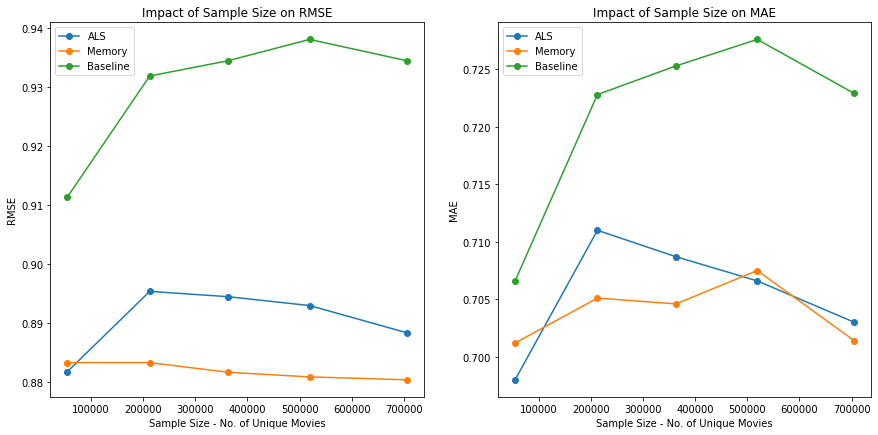

In [299]:
plt.subplots_adjust(0.1, 0.1, 2, 1.4)

plt.subplot(1, 2, 1)
plt.plot(scalability_perform_als['sample_size'], scalability_perform_als['rmse'], marker='o')
plt.plot(scalability_perform_memory['sample_size'], scalability_perform_memory['rmse'], marker='o')
plt.plot(scalability_perform_base['sample_size'], scalability_perform_base['rmse'], marker='o')
plt.legend(['ALS', 'Memory', 'Baseline'])
plt.title('Impact of Sample Size on RMSE')
plt.xlabel('Sample Size - No. of Ratings')
plt.ylabel('RMSE')

plt.subplot(1, 2, 2)
plt.plot(scalability_perform_als['sample_size'], scalability_perform_als['mae'], marker='o')
plt.plot(scalability_perform_memory['sample_size'], scalability_perform_memory['mae'], marker='o')
plt.plot(scalability_perform_base['sample_size'], scalability_perform_base['mae'], marker='o')
plt.legend(['ALS', 'Memory', 'Baseline'])
plt.title('Impact of Sample Size on MAE')
plt.xlabel('Sample Size - No. of Ratings')
plt.ylabel('MAE')

plt.show()

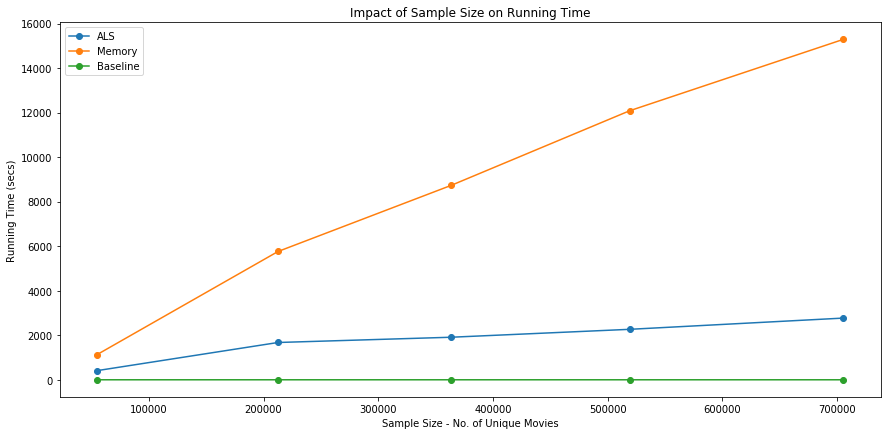

In [300]:
plt.subplots_adjust(0.1, 0.1, 2, 1.4)

plt.plot(scalability_perform_als['sample_size'], scalability_perform_als['elapsed_time'], marker='o')
plt.plot(scalability_perform_memory['sample_size'], scalability_perform_memory['elapsed_time'], marker='o')
plt.plot(scalability_perform_base['sample_size'], scalability_perform_base['elapsed_time'], marker='o')
plt.legend(['ALS', 'Memory', 'Baseline'])
plt.title('Impact of Sample Size on Running Time')
plt.xlabel('Sample Size - No. of Ratings')
plt.ylabel('Running Time (secs)')
plt.show()

* *How do the evaluation metrics change as a function of your model size? Change your data set size by sampling your data from a small size to a large size*

*Impact of Sample Size on Accuracy*

As sample size increases, the RMSE value initially shoots up and then starts to decrease for the ALS model but it stays rather consistent and decreases for the item-item memory based model. As for each sample, the ALS model learns new set of hyperparameters on the validation dataset, and accuracy is reported above is on test dataset, this behavior is expected. On comparison with baseline model, both item-item memory based and ALS model perform better. 

In case of MAE, there is no conclusive evidence which model is better among item-item memory based and ALS model, though ALS maintains a similar trend to RMSE where it initially shoots up and then starts to decrease. However, both models were found to be better than the baseline model.

*Impact of Sample Size on Running Time*

As expected, the running time of baseline model is lower than the two models we implemented. Since the baseline model does not learn from any user-movie rating interactions, the computation is less intensive and this behavior is consistent as sample size increases. In between ALS model and item-item memory based model, the computation for ALS model is much faster as it was run on a distributed Spark platform. Hence ALS offers better scalability.

#### 8. Conclusion & Future Work <a id = conclusion></a>

* *How does your recommendation system meet your hypothetical objectives? Would you feel comfortable putting these solutions into production at a real company? What would be the potential watch outs?*

* *After seeing these results, what other design choices might you consider in order to have a more accurate or more useful model?*

*Conclusion*

Our objective was to show that having a collaborative filtering based recommendation system that learns user behavior will outperform a baseline algorithm that simply recommends top-k highly rated movies for each user. We can see that both item-item memory based and ALS model based collaborative filtering algorithms give us significant bump in model accuracy, measured in terms of RMSE and MAE. In that sense, we have accomplished our objective. 

To productionalize a recommendation system in a work setting, we have to put emphasis on how well our model scales as the amount of data increases. As observed, as the size of our data increases the algorithm does not drop too much in accuracy and manages to maintain similar level of RMSE and MAE. And though there are dips in accuracy, it is expected as increasing the dataset leads to increase in noise in our data. To tackle this, we may want to add additional business rules or tune hyperparameters over a larger set of combinations, which a data scientist needs to continously explore as data grows over time.

*Future Work*

As both the models deployed here, are based on explicit features, we have the potential to improve our model by including implicit user or item feedback. We can perform collective matrix factorization by imputing genre information alongside movie ratings as it is a logical assumption that users show preference of certain genre(s) of movies. We could utilize external data sources such as IMDB movie ratings, movie cast, etc. to further improve our model. We should also explore deep learning algorithms for recommender systems and compare with collaborative filtering algorithms in terms of scalability.

We also want to solve for cold-start problem so that we can stop eliminating users who have inadequate ratings from our analysis. We have achieved a good user coverage in our existing implementation because we are not considering such users. As we include implicit user behavior and provide recommendations, we should revisit user coverage and evaluate our model. Lastly, we would want to include diversity and novelty in the recommendations that we provide to the user. If we tackle this in the correct way, this would help the organization in the long run through customer retension and possibly acquisition. 

As an initial version of the recommendation system is put in place, we need to plan ahead and build a pipeline of additional features and functionality we want added to our system. Considering both feasibility and monetary benifit of each feature/functionality, we can define the priorities. At every stage we would choose to productionalize the new model only if it performs better than the existing model, which acts as our new baseline.